In [3]:
import os
import re
import random
import time
import statistics
from glob import glob

import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import TwoSlopeNorm
from scipy.io import loadmat
from scipy.spatial.distance import pdist, squareform

In [12]:
# royal_blue = [0, 20/256, 82/256]

def get_tag_paths(zebfolderpath):
    tag = re.findall(r'z.*f\d+', zebfolderpath)[0]

    files = os.listdir(zebfolderpath)
    files.sort()
    files.remove("README_LICENSE.rtf")

    path0, path1 = [zebfolderpath + "/" + fname for fname in files]

    return tag, path0, path1


def read_data(path0, path1, num_rois, scells=True):
    dholder = h5py.File(path0, "r")
    d0 = dholder["CellResp"][:]  # responses
    d1 = loadmat(path1, simplify_cells=scells)

    eliminated_rois = d1["data"]["IX_inval_anat"] # 
    all_rois = d1["data"]["CellXYZ"] # roi positions x, y, z

    used_rois_coor = np.array(
        [row for j, row in enumerate(all_rois) if j not in list(eliminated_rois)]
    )

    x, y, z = used_rois_coor[:num_rois, :].T

    return x, y, z, d0


def get_n_nearest_nbrs(ds, roi_idx, n=10):
    nn_idx = ds[roi_idx,].argsort()[1 : n + 1]

    return nn_idx


def get_n_nearest_nbrs_dist(ds, roi_idx, n=10):
    nn_dists = ds[roi_idx][ds[roi_idx,].argsort()][1 : n + 1]

    return nn_dists
 
def compute_distance_matrix(x, y):
     ds = squareform(pdist(np.array([x, y]).T, metric="euclidean"))
 
     return ds
 

def get_n_random_nbrs(roi_idx, len0=100, n=10):

    all_idx = list(range(len0))
    all_idx.remove(roi_idx)
    rn_idx = random.sample(all_idx, n)

    return rn_idx


def get_roi_indices_region(xall, yall, x0=None, y0=None, x1=None, y1=None):
    '''returns roi indices for given  square region where (x0 < x < x1), (y0 < y < y1)'''
    ''' possibly extend of circular region'''
    inxy  = np.where(((xall > x0) & (xall < x1)) & ((yall > y0) & (yall < y1)))[0]
    return inxy


def get_roi_positions(inxy):
    '''returns the (x, y) for rois given the indices'''
    x, y = x[inxy], y[inxy] 
    return x, y

def compute_n_nearest_nbrs_corr_for_roi(
        roi_idx, 
        d0, 
        dS,
        neigh_pop, 
    ):
    """ return for correlations given roi_index, 
        of length n  for nearest neighbours 
        """

    # create arrays to store values
    nncorrs_per_roi = np.empty(neigh_pop, dtype=float) 

    # get signal for roi_index
    roi_response = d0[:, roi_idx]

    # get n random and nearest neighbours
    nn_idx = get_n_nearest_nbrs(dS, roi_idx, n=neigh_pop)

    # get nearest and random neighbours responses
    nnrois_responses = d0[:, nn_idx]

    # compute nn and rn correlations 
    for j in range(neigh_pop):
        nn_corr = np.corrcoef(roi_response, nnrois_responses[:, j])[0, 1]
        nncorrs_per_roi[j] = nn_corr

    return nncorrs_per_roi


def compute_n_random_nbrs_corr_for_roi(
        roi_idx, 
        d0, 
        neigh_pop, 
        num_rois,
    ):
    """ return for given roi_index, two arrays of correlations 
        of length n;one for nearest neighbours, 
        another for random neighbours """

    # create arrays to store values
    rncorrs_per_roi = np.empty(neigh_pop, dtype=float) 

    # get signal for roi_index
    roi_response = d0[:, roi_idx]

    # get n random and nearest neighbours
    rn_idx = get_n_random_nbrs(
                               roi_idx, 
                               len0=num_rois,  
                               n=neigh_pop,
            ) 

    # get nearest and random neighbours responses
    rnrois_responses = d0[:, rn_idx]

    # compute nn and rn correlations 
    for j in range(neigh_pop):
        rn_corr = np.corrcoef(roi_response, rnrois_responses[:, j])[0, 1]
        rncorrs_per_roi[j] = rn_corr

    return  rncorrs_per_roi


# Compute the radial cscale of data, to get a sense of the size of the neighbourhoods
def compute_radial_scale_for_n_nbrs(ds, num_rois, neigh_pop):
    """Return mean radial scale for number of rois used."""
    max_dists = np.empty(num_rois, dtype=float)
    for roi_idx in range(num_rois):
        dists = get_n_nearest_nbrs_dist(ds=ds, roi_idx=roi_idx, n=neigh_pop)
        max_dists[roi_idx] =  dists.max()

    radial_scale = max_dists.sum()/ num_rois
    
    return radial_scale, max_dists


# set params 

In [5]:
num_rois = 2000
seed = None
nnpop = 10
fileDir = "/Users/duuta/ppp/data/zebf00/"
sdir = None
rnpop = 10 

# get data and vars using defined params 

In [6]:
tag, path0, path1 = get_tag_paths(fileDir)

# read file paths
x, y, _, d0 = read_data(path0, path1, num_rois=num_rois, scells=True)
print("can read the file path... yes.... frantically reading files.....")

# compute distances between rois
dS = compute_distance_matrix(x, y)

print("franticall computing distances......")

can read the file path... yes.... frantically reading files.....
franticall computing distances......


In [7]:
def compute_render_ratio_corr(
    x, y,
    d0, dS, 
    num_rois=30000, 
    nnpop=10, rnpop=10, 
    seed=None, 
    tag=None, 
    sdir=None, 
    figsize=(10, 10), 
    edgecolor='white', 
    marker_size=10, 
    radius=10,
    circle_patch=True,
    target0 =None,
    target1 =None,
):
    nnidx_dict = {}
    rnidx_dict = {}
    nncorr_dict = {}
    rncorr_dict = {}
    collect_nn_min_max = []
    collect_rn_min_max = []

    # get rois in given region
    target_rois_list =  get_roi_indices_region(x, y, x0=1400, x1=1600, y0=400, y1=500)

    # compute roc for rois of given index 
    ## create function to compute roi for given roi
    for roi_idx in range(
        num_rois
    ):  # need to account for cases where the pass a list of roi indices
        random.seed(seed)
        roi = d0[:, roi_idx]
        nn_idx = get_n_nearest_nbrs(dS, roi_idx, n=nnpop)
        nn_roi = d0[:, nn_idx]
        rn_idx = get_n_random_nbrs(roi_idx, len0=num_rois, n=rnpop)
        rn_roi = d0[:, rn_idx]
        nrcorr = []
        rncorr = []

        for j in range(nn_roi.shape[1]):
            nn_corr = np.corrcoef(roi, nn_roi[:, j])[0, 1]
            rn_corr = np.corrcoef(roi, rn_roi[:, j])[0, 1]
            nrcorr.append(nn_corr)
            rncorr.append(rn_corr)
            collect_nn_min_max.append(nn_corr)
            collect_rn_min_max.append(rn_corr)

        nnidx_dict[roi_idx] = nn_idx
        rnidx_dict[roi_idx] = rn_idx
        nncorr_dict[roi_idx] = nrcorr  # groups of near correlations
        rncorr_dict[roi_idx] = rncorr  # groups of random correlations


    fig0 = plt.figure(figsize=figsize)
    custom_norm = TwoSlopeNorm(vcenter=1, vmin=0.001, vmax=9)
    ax = plt.axes()

    for roi_idx in range(
        num_rois
    ):  # need to take care of cases where num_rois is of indexes
        roc = round(np.array(nncorr_dict[roi_idx]).sum() \
                / np.array(rncorr_dict[roi_idx]).sum(), 3)

        ps0=plt.scatter(
            x[nnidx_dict[roi_idx]],
            y[nnidx_dict[roi_idx]],
            marker=".",
            norm=custom_norm,
            cmap="rainbow",
            s=marker_size,
            c=[roc]
            * len(nnidx_dict[roi_idx]) 
        )
        if roi_idx in target_rois_list[:1]:
            roi_x, roi_y = x[roi_idx], y[roi_idx]

            # get current axis and inset new  axes.
            ax0=plt.gca().inset_axes((0.01, 0.2, 0.5, 0.1), facecolor='white')

            # Create a (3, 2) grid
            # Create the top subplot spanning the first two columns
            [ ax1, ax2, ax3 ]= ax0.subfigures(3, 1)
            ax1.plot(d0[:, roi_idx][80:1880], 
                     color='blue',  
                     linewidth=0.5, 
                     label=f'Target Neuron {roi_idx} : roc={roc}' 
            )
            ax1.legend(labelcolor='black')
            ax1.set_yticks([])
            ax1.set_xticks([])


            # Create the second subplot in the second column
            ax2.plot(d0[:, roi_idx][80:1880], 
                     color='blue',  
                     linewidth=0.5, 
                     label=f'Target Neuron {roi_idx} : roc={roc}' )
            ax2.legend(labelcolor='black')
            ax2.set_yticks([])
            ax2.set_xticks([])


            # Create the fourth subplot in the third column
            ax3.plot(d0[:, roi_idx][80:1880], color='blue',  linewidth=0.5, 
                     label=f'Target Neuron {roi_idx} : roc={roc}' )
            ax3.legend(labelcolor='black')
            ax3.set_yticks([])
            ax3.set_xticks([])

            # annotate inset plot
            #plt.annotate(f"ROI:{roi_idx}",
            #             xy = ("xy for top right corner of inset plot"),
            #             xytext=(roi_x, roi_y),
            #             arrowprops=dict(arrowstyle="fancy",
            #                color="white",
            #                shrinkB=5,
            #                connectionstyle="arc3,rad=0.3",
            #            ),
            #) 
            
               # need to come back to this... 
    #nn_dist = find_nearest_nbrs_dist(dS, roi_idx)
    #radius =  max(nn_dist)/num_rois

    if circle_patch:
        plt.gca().add_patch(plt.Circle((200, 50), radius=radius, facecolor='none', edgecolor='white', linewidth=2.5))

    plt.colorbar(ps0, spacing='proportional', shrink=0.5).ax.set_yscale('linear')
    plt.xlabel("ROI X Positions", fontsize=20)
    plt.ylabel("ROI Y Positions", fontsize=20)
    #plt.grid(color='white')
    plt.margins(x=0, y=0)
    plt.title(
        f"{tag}:Raw correlation ratios of near ROIs:{nnpop} to random ROIs:{rnpop} seed:{seed}",
        fontsize=20,
    )
    ax.set_facecolor("black")
    plt.tight_layout()
    if sdir:
        plt.savefig(
            f"{sdir}testing_Rawratiocorrelations_{tag}_ROIs:{num_rois}_NN:{nnpop}_seed:{seed}_RN:{rnpop}.png",
        )
    else:
        plt.show()
        
    plt.close()
    # need to run this for different vmax, vmin, mid=1 (first make a function initerim a class later)


In [8]:
def compute_render_ratio_corr0(
    x, y,
    d0, dS, 
    num_rois=30000, 
    nnpop=10, rnpop=10, 
    seed=None, 
    tag=None, 
    sdir=None, 
    figsize=(10, 10), 
    edgecolor='white', 
    marker_size=10, 
    radial_scale=10,
    circle_patch=False,
    tar0_idx=None,
    high_target_rois_list = None, 
):
    nn_corrs = np.empty(num_rois, dtype=float)
    rn_corrs = np.empty(num_rois, dtype=float)

    # get rois in given region
    target_rois_list =  get_roi_indices_region(x, y, x0=1400, x1=1600, y0=400, y1=500)

    # compute roc for rois of given index 
    ## create function to compute roi for given roi
    for roi_idx in range(
        num_rois
    ):  # need to account for cases where the pass a list of roi indices
        random.seed(seed)
        nncorrs_per_roi = compute_n_nearest_nbrs_corr_for_roi(
             roi_idx=roi_idx,
             d0=d0,
             dS=dS,
             neigh_pop=10,
        )
        rncorrs_per_roi = compute_n_random_nbrs_corr_for_roi(
            roi_idx=roi_idx,
            d0=d0,
            neigh_pop=10,
            num_rois=2000, 
        )

        nn_corrs[roi_idx] = nncorrs_per_roi.sum()
        rn_corrs[roi_idx] = rncorrs_per_roi.sum()

    # compute roc for data
    roc = (( nn_corrs  ) / (rn_corrs + 2)).round()
    print(roc.shape)

    # get high correlation target & positions
    tar0_idx_high = high_target_rois_list[0]

    # get sample targets & target positions
    tar00_idx = target_rois_list[1]
    tar01_idx = target_rois_list[2]
    tar02_idx = target_rois_list[3]
    
    tar0_x, tar0_y = x[tar0_idx], y[tar0_idx]
    tar00_x , tar00_y = x[tar00_idx], y[tar00_idx]
    tar01_x , tar01_y= x[tar01_idx], y[tar01_idx]

    # get poistion of high corrs
    tar0_high_x, tar0_high_y = x[tar0_idx_high], y[tar0_idx_high] 


    # target rois neighbours for low regions
    tar00_nn_corr = compute_n_nearest_nbrs_corr_for_roi(
         roi_idx=tar00_idx,
         d0=d0,
         dS=dS,
         neigh_pop=2,
    )

    tar00_nn_idx = get_n_nearest_nbrs(
        roi_idx=tar00_idx,
        ds=dS,
        n=2,
    )

    # target rois neighbours for high regions
    tar0_nn_corr_high = compute_n_nearest_nbrs_corr_for_roi(
        roi_idx = tar0_idx_high,
        d0=d0,
        dS =dS,
        neigh_pop=2
    )

    tar0_nn_idx_high = get_n_nearest_nbrs(
            roi_idx=tar0_idx_high,
            ds=dS,
            n=2,
        )
   
    tar0_high_x, tar0_high_y = x[tar0_idx_high], y[tar0_idx_high]
    tar0_high_nn0_x, tar0_high_nn0_y = x[tar0_nn_idx_high[0]], y[tar0_nn_idx_high[0]]
    tar0_high_nn1_x, tar0_high_nn1_y = x[tar0_nn_idx_high[0]], y[tar0_nn_idx_high[0]]

    # get random neighbours 
    

    fig0 = plt.figure(figsize=figsize)
    custom_norm = TwoSlopeNorm(vcenter=1, vmin=roc.min(), vmax=roc.max())
    ax = plt.axes()
        
    ps0=plt.scatter(
            x[:num_rois],
            y[:num_rois],
            marker=".",
            norm=custom_norm,
            cmap="rainbow",
            s=marker_size,
            c=roc,
    )

################  ###  # get current axis and inset new axes for  high correlations 
    ax0=plt.gca().inset_axes((0.01, 0.8, 0.5, 0.1), facecolor='white')
    offset = 0
    for roi_idx in high_target_rois_list[:3]:
        ax0.plot(d0[:, roi_idx][80:1880] + offset, 
             linewidth=0.5, 
        )
        offset = np.std(d0[:, roi_idx]) 

    ax0.legend([f'Target Neuron {tar0_idx_high} : roc={round(roc[tar0_idx_high], 3)}', 
                f'NN0:{tar0_nn_idx_high[0]} : cor={round(tar0_nn_corr_high[0], 3)}', 
                f'NN1:{tar0_nn_idx_high[1]} : cor={round(tar0_nn_corr_high[1], 3)}'], 
                labelcolor='black')
    ax0.set_yticks([])
    ax0.set_xticks([])

    # specify color of arrows by color of signal using facecolor
    plt.gca().annotate(f"ROI:{tar0_idx_high}",
                       color ='white',
                       xy = (1050, 950), 
                       xytext=(tar0_high_x, tar0_high_y),
                       arrowprops=dict(arrowstyle="fancy",
                                        facecolor='blue',
                                        patchB=ax0,
                                        shrinkB=5,
                                        connectionstyle="arc3,rad=0.3",
                                    ),
                    ) 
    plt.gca().annotate(f"ROI:{tar0_nn_idx_high[0]}",
                        color = "white",
                        xy = (1050, 950), # need to set this as the top right corner of inset plot 
                        xytext=(tar0_high_nn0_x, tar0_high_nn0_y),
                        arrowprops=dict(arrowstyle="fancy",
                                       facecolor="orange",
                                       patchB=ax0,
                                       shrinkB=5,
                                       connectionstyle="arc3,rad=0.3",
                                    ),
                    )
    plt.gca().annotate(f"ROI:{tar0_nn_idx_high[1]}",
                       color='white',
                       xy = (1050, 950),
                       xytext=(tar0_high_nn1_x, tar0_high_nn1_y),
                       arrowprops=dict(arrowstyle="fancy",
                                       facecolor="green",
                                       patchB=ax0,
                                       shrinkB=5,
                                       connectionstyle="arc3,rad=0.3",
                                    ),
                    )
#######   # get current axis and inset new axes for low corrs 
    ax0=plt.gca().inset_axes((0.01, 0.2, 0.5, 0.1), facecolor='white')
    offset = 0
    for roi_idx in target_rois_list[:3]:
        ax0.plot(d0[:, roi_idx][80:1880] + offset, 
             linewidth=0.5, 
        )
        offset = np.std(d0[:, roi_idx]) 

    ax0.legend([f'Target Neuron {tar00_idx} : roc={round(roc[tar00_idx], 3)}', 
                f'NN0:{tar00_nn_idx[0]} : cor={round(tar00_nn_corr[0], 3)}', 
                f'NN1:{tar00_nn_idx[1]} : cor={round(tar00_nn_corr[1], 3)}'], 
                labelcolor='black')
    ax0.set_yticks([])
    ax0.set_xticks([])

    # specify color of arrows by color of signal using facecolor
    plt.gca().annotate(f"ROI:{tar0_idx}",
                       color ='white',
                       xy = (1050, 350),
                       xytext=(tar0_x, tar0_y),
                       arrowprops=dict(arrowstyle="fancy",
                                        facecolor='blue',
                                        patchB=ax0,
                                        shrinkB=5,
                                        connectionstyle="arc3,rad=0.3",
                                    ),
                    ) 
    plt.gca().annotate(f"ROI:{tar00_idx}",
                        color = "white",
                        xy = (1050, 350), # need to set this as the top right corner of inset plot 
                        xytext=(tar00_x, tar00_y),
                        arrowprops=dict(arrowstyle="fancy",
                                       facecolor="orange",
                                       patchB=ax0,
                                       shrinkB=5,
                                       connectionstyle="arc3,rad=0.3",
                                    ),
                    )
    plt.gca().annotate(f"ROI:{tar01_idx}",
                       color='white',
                       xy = (1050, 350),
                       xytext=(tar01_x, tar01_y),
                       arrowprops=dict(arrowstyle="fancy",
                                       facecolor="green",
                                       patchB=ax0,
                                       shrinkB=5,
                                       connectionstyle="arc3,rad=0.3",
                                    ),
                    ) 
    # need to come back to this... 
    #nn_dist = find_nearest_nbrs_dist(dS, roi_idx)
    #radius =  max(nn_dist)/num_rois

    if circle_patch:
        plt.gca().add_patch(plt.Circle((200, 50), radius=radial_scale, facecolor='none', edgecolor='white', linewidth=2.5))

    plt.colorbar(ps0, spacing='proportional', shrink=0.5).ax.set_yscale('linear')
    plt.xlabel("ROI X Positions", fontsize=20)
    plt.ylabel("ROI Y Positions", fontsize=20)
    #plt.grid(color='white')
    plt.margins(x=0, y=0)
    plt.title(
        f"{tag}:Raw correlation ratios of near ROIs:{nnpop} to random ROIs:{rnpop} seed:{seed}",
        fontsize=20,
    )
    ax.set_facecolor("black")
    plt.tight_layout()
    if sdir:
        plt.savefig(
            f"{sdir}testing_Rawratiocorrelations_{tag}_ROIs:{num_rois}_NN:{nnpop}_seed:{seed}_RN:{rnpop}.png",
        )
    else:
        plt.grid(color='white')
        plt.show()
        
    plt.close()
    # need to run this for different vmax, vmin, mid=1 (first make a function initerim a class later)

    return roc


# compute ratio of correlations

(2000,)


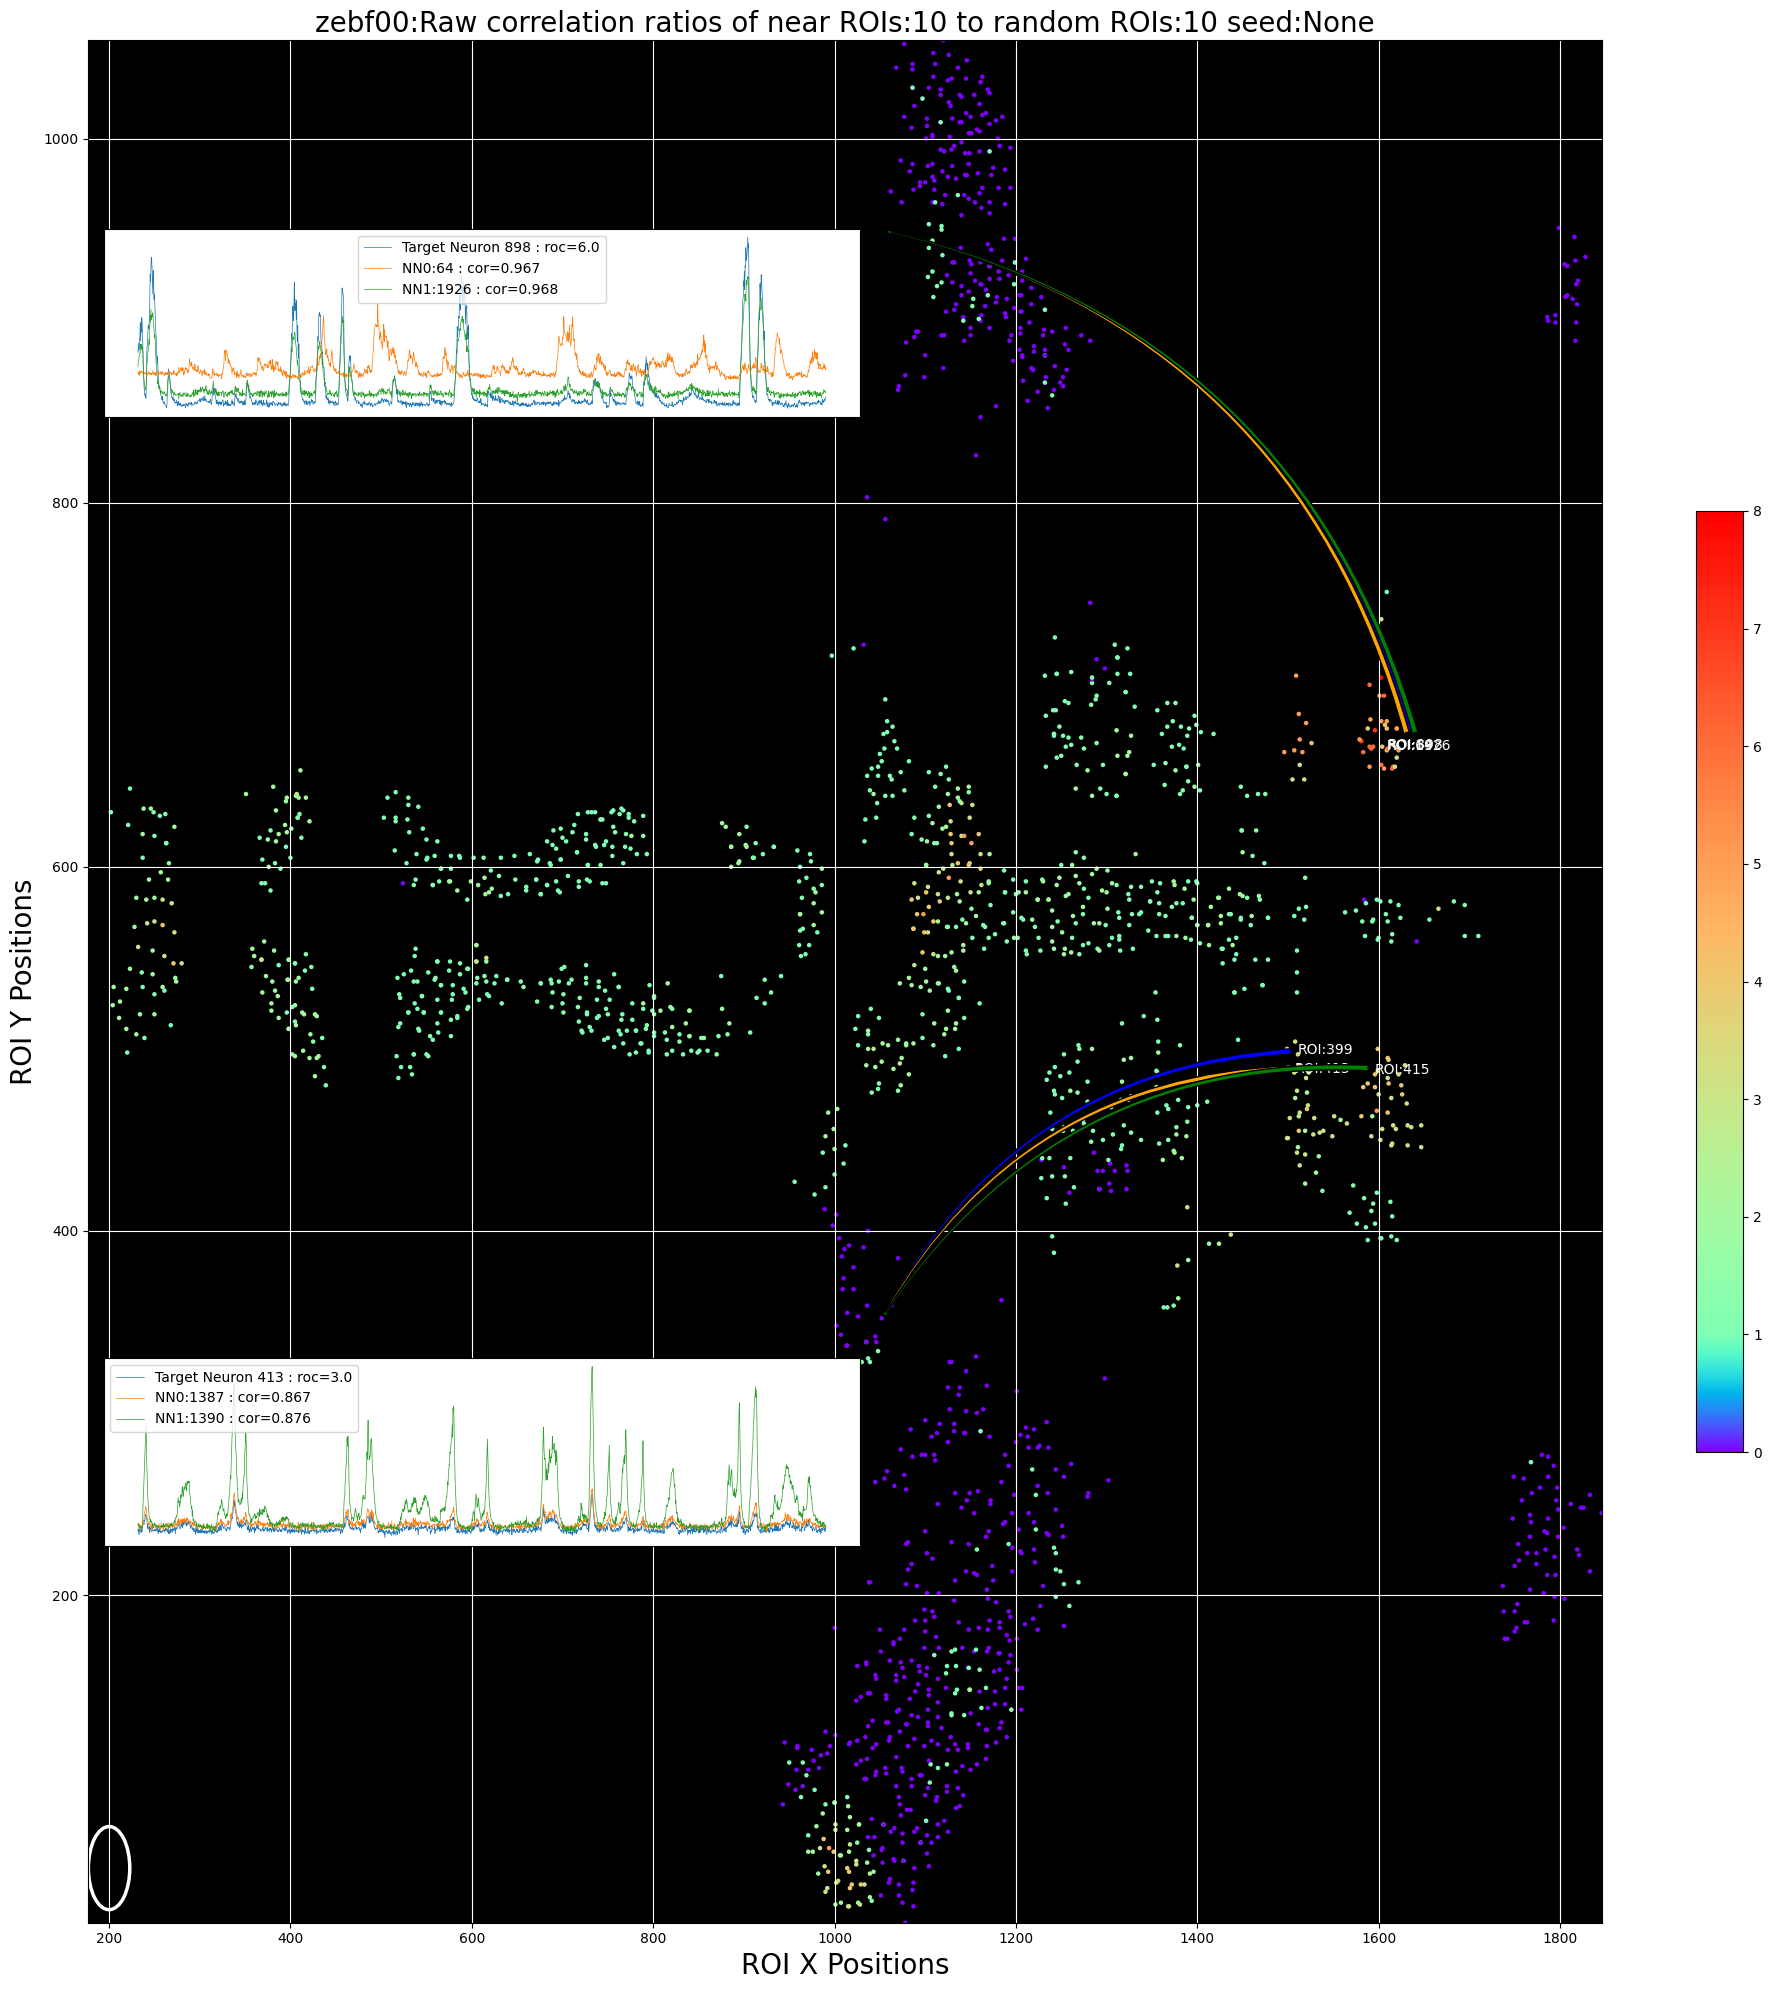

In [124]:
# compute correlation ratio and render plot
rooc =compute_render_ratio_corr0(
    x,
    y,
    d0=d0,
    dS=dS,
    num_rois=num_rois,
    nnpop=nnpop,
    rnpop=rnpop,
    seed=seed,
    tag=tag,
    sdir=sdir,
    radial_scale=radial_scale0,
    figsize=(20, 20),
    tar0_idx=399,
    marker_size=20,
    circle_patch=True,
    high_target_rois_list=high_target_rois_list,
)

In [66]:
# need to check this function.
def compute_radial_scale_for_n_nbrs(ds, num_rois, neigh_pop):
    """Return mean radial scale for number of rois used."""
    max_dists = np.empty(num_rois, dtype=float)
    for roi_idx in range(num_rois):
        dists = get_n_nearest_nbrs_dist(ds=ds, roi_idx=roi_idx, n=neigh_pop)
        max_dists[roi_idx] =  dists.max()

    radial_scale = max_dists.sum()/ num_rois
    
    return radial_scale, max_dists

In [68]:
radial_scale0, max_dists = compute_radial_scale_for_n_nbrs(ds=dS, num_rois=2000, neigh_pop=10)

In [69]:
radial_scale0

22.819423613649857

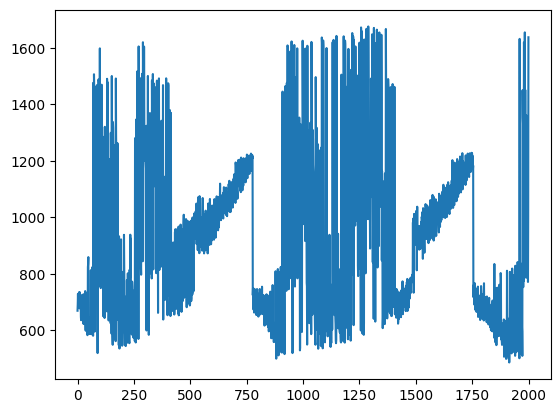

In [386]:
plt.plot(dists)

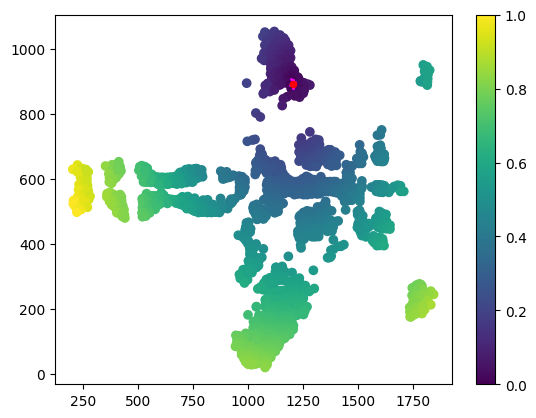

In [44]:
ind_choice = random.choice(np.arange(len(x)))
five_nearest_neigh_ind_choice = get_n_nearest_nbrs(dS, ind_choice, 10)

plt.scatter(x, y, c=max_dists, s=1)
plt.scatter(x, y, c=dS[ind_choice])
plt.scatter(x[five_nearest_neigh_ind_choice], y[five_nearest_neigh_ind_choice], c='magenta', s=1)
plt.scatter(x[ind_choice], y[ind_choice], color='r', s=20)
plt.colorbar()

In [24]:
ind_choice

30

In [25]:
five_nearest_neigh_ind_choice = get_n_nearest_nbrs(dS, ind_choice, 5)

In [26]:
five_nearest_neigh_ind_choice

array([ 851, 1841,  845,  847, 1845])

In [65]:
get_n_nearest_nbrs_dist(dS, ind_choice, 10)

array([ 3.        ,  9.05538514, 10.04987562, 11.66190379, 12.        ,
       12.04159458, 12.16552506, 12.64911064, 13.15294644, 15.65247584])

In [63]:
dS[ind_choice][dS[ind_choice].argsort()][1:10+1]

array([ 3.        ,  9.05538514, 10.04987562, 11.66190379, 12.        ,
       12.04159458, 12.16552506, 12.64911064, 13.15294644, 15.65247584])

Text(0, 0.5, 'Ratio of correlations')

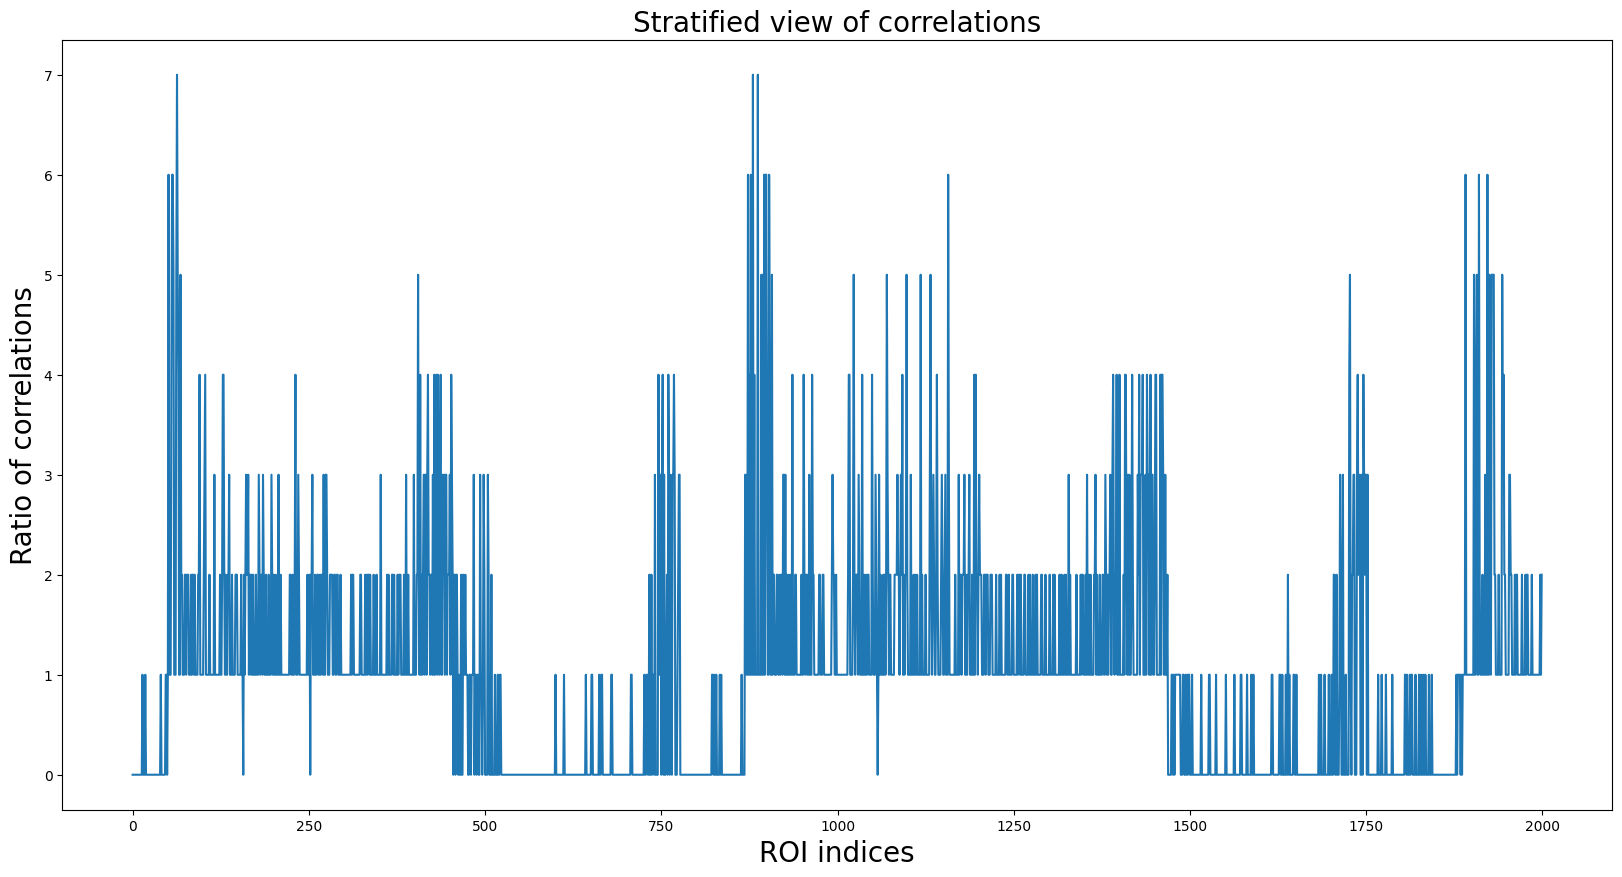

In [353]:
fig00 = plt.figure(figsize=(20, 10))
plt.plot(rooc)
plt.title("Stratified view of correlations", fontsize=20)
plt.xlabel('ROI indices', fontsize=20)
plt.ylabel('Ratio of correlations', fontsize=20)

In [ ]:
 # we expect the roc to change (for our scale is it rather slight, maintaining still high figures, this something we were not accounting in our thinking)

In [89]:
# return indexes for roc == 7 

(rooc ==7).nonzero()

(array([ 51,  63, 887, 896]),)

In [111]:
(rooc>= 7).nonzero()[0]

array([  62,  892,  896,  898,  899, 1017])

In [113]:
# implement later, useful for certain computations 
def find_rois_with_given_corr_or_range_of_corr(roc0, start=None, end=None):
    """Return roi indexs for a given corr or range of corr values"""
    if not end:
        inxs = (roc0 == start).nonzero()
    else:
        inxs = ((roc0 >= start) & (roc <= end)).nonzero()
    raise "Not Implemented"

In [114]:
(rooc == 8).nonzero()

(array([ 898, 1017]),)

In [115]:
high_target_rois_list  = [898, 1017, 62, 892, 898]

# Poorly Sensed ROIs

In [ ]:
d0.shape

In [ ]:
for neuron_index in range(2000):
    plt.plot(d0[:, neuron_index])

In [ ]:
def get_roi_index_from_position(x, y, x0, y0):
    return np.intersect1d((np.nonzero(x == x0)), (np.nonzero(y== y0)))[0]

* make arrow bigger, otherwise, use plt.arrow() which is straighted --- done
* time axis for the bottom  
* stimulus oneset times.
    ** example
    ** peroids = 480 
    ** timelists = [1, ..,2880] which were are already ploting for the x axis for each signal.
    ** considered writing to Misha but not very good at feedback.
    ** could ask Emmanuel when we have a call later this week. 
* fluctuations due to stimulus or something else.
* something to think about:
* common input could drive neurons to behave similar () # spontaneous activity resolves this problem.
* sliddling window correlations


* need to fix the colorbar scale --- done
* how to choose small offset to avoid division by zero, I remeber Sina suggesting addition of 2. -- done
* need replace the version of the code on nemo and run for all datasets to see what structure appears --- [ resolved connection issues with nemo, need to update code and ran the code for the curr pipeline]
* need to set the radial scale with actual data. --- done
* set endpoints for arrows for annotations, -- done ( see 7)
* how to sync colors in annotate (can ask Sina later)
* need to exactly compute the top right corner coordinates of the inset axes plot. ((x, y) + width)
* ask Sina about why one chooses n-1 splines in cubic splines. 
* need to setup github.
* inset axes for low roc values. [do it after meeting with Sina Tomorrow]
* function for sanity checking roc values overlaying signals to verify visually the computation.
* Does make sense to have different populations of neighbors, no?
* overlay plot with loose anatomical map

* consider implementing a class for the task the ROI tasks

* for roi plot get n nn_neighbours
* get n random neighbours
* compute correlations
* plot signals labeling with correlation values

In [17]:
rid = 0
nn_three  = get_n_nearest_nbrs(dS, rid, n=3)
rn_three  = get_n_random_nbrs(rid,len0=20, n=3)
nn_three_corr = compute_n_nearest_nbrs_corr_for_roi(rid, d0, dS, 10)
rn_three_corr = compute_n_random_nbrs_corr_for_roi(rid, d0, 10, 100)

In [1]:
def sort_rois_in_plot_layout(roi, nn_arr, rn_arr):
    n = 2 + 2 * len(rn_arr)
    ls0 = [roi]*n
    for i, (nn, rn) in enumerate(zip(nn_arr, rn_arr)):
        ls0[2*i+2] = nn
        ls0[2*i+3] = rn
    return ls0

def render_signal_correlations_for_roi(d0, roi, nn_arr, rn_arr, roi_roc, nn_corr, rn_corr):
    """ Plots the signals or near and random neighs for visual comparisions"""
    # sort rois for plot layout
    ls_roi_idx  = sort_rois_in_plot_layout(roi, nn_arr, rn_arr)

    # compute nrows for plot
    nrows = int(len(ls_roi_idx)/2)
    ls0_iter = iter(ls_roi_idx)
    
    # sort correlations
    ls_roi_corr = sort_rois_in_plot_layout(roi_roc, nn_corr, rn_corr)
    ls_roi_corr_iter = iter(ls_roi_corr)

    fig, axs = plt.subplots(ncols=2, nrows=nrows, figsize=(15, 4),
                            layout="constrained")
    # for each Axes, add an artist, in this case a nice label in the middle...
    for row in range(4):
        for col in range(2):
            idx = next(ls0_iter) # get index of next plot
            cori = round(next(ls_roi_corr_iter), 3)

            if (row > 0) & (col == 1):
                # plotting random neighbours
                axs[row, col].plot(d0[:, idx][80:1880], linewidth=0.5, label=f'{idx}:{cori}',  color='orange' )

            elif row == 0:
                # plotting main signal
                axs[row, col].plot(d0[:, idx][80:1880],  linewidth=0.5, color= 'blue', label=f'{idx}:{cori}')

            else:
                # plotting near neighbours
                axs[row, col].plot(d0[:, idx][80:1880],  linewidth=0.5, color='red', label=f'{idx}:{cori}')

            #axs[row, col].text(-1, -0.1, s=f'{idx}:{cori}', color='red')
            axs[row, col].legend(handlelength=0, fontsize='large', loc='lower left', labelcolor='black', frameon=False)
            axs[row, col].set_xticks([])
            axs[row, col].set_yticks([])
            axs[row, col].margins(x=0)
            axs[row, col].annotate(f'', (0.5, 0.5),
                                transform=axs[row, col].transAxes,
                                ha='center', va='center', fontsize=18,
                                color='darkgrey')
                

    axs[3, 0].set_xticks([0, 1800])
    axs[3, 1].set_xticks([0, 1800])
    axs[0, 0].set_title('Main ROI, ROI IDX : ROC', loc='left', fontsize='medium') 

    #axs[1, 0].set_title('Nearest Neighbours', loc='left', fontsize='medium') 
    #axs[1, 1].set_title('Random Neighbours', loc='right', fontsize='medium') 

    fig.suptitle("Correlations Sanity Check: Rendering correlations for given ROI")
    plt.show()

    

    return None

In [18]:
def compute_roc(nn_corr, rn_corr):
    roc = ( nn_corr.sum() / 2 + rn_corr.sum()) 
    return roc

In [19]:
roi_roc = compute_roc(nn_three_corr, rn_three_corr)

In [220]:
d0.max()

16.765734

* change position of text
* tighten each axes or remove plot spaces
* 

In [ ]:
inset_positions_high = (0.01, 0.2, 0.5, 0.1)
inset_positions_low = (0.01, 0.2, 0.5, 0.1)

In [9]:
def insert_inset_plot_seg(
      roc, 
      tar0_idx_high,
      tar0_nn_idx_high,
      tar0_nn_corr_high,
      inset_axes_coors = (),
      target_rois_list = None, 
      tar0_rn_idx_high=None,  
      tar0_rn_corr_high=None,
):
      # get (x, y) for rois
      ax0=plt.gca().inset_axes((0.01, 0.2, 0.5, 0.1), facecolor='white')
      offset = 0
      for roi_idx in target_rois_list[:3]:
        ax0.plot(d0[:, roi_idx][80:1880] + offset, 
             linewidth=0.5, 
        )
        offset = np.std(d0[:, roi_idx]) 

      # get positions from within function
      tar0_high_x, tar0_high_y = x[tar0_idx_high], y[tar0_idx_high]
      tar0_high_nn0_x, tar0_high_nn0_y = x[tar0_nn_idx_high[0]], y[tar0_nn_idx_high[0]]
      tar0_high_nn1_x, tar0_high_nn1_y = x[tar0_nn_idx_high[0]], y[tar0_nn_idx_high[0]]


      ax0.legend([f'Target Neuron {tar0_idx_high} : roc={round(roc[tar0_idx_high], 3)}', 
                   f'NN0:{tar0_nn_idx_high[0]} : cor={round(tar0_nn_corr_high[0], 3)}', 
                   f'NN1:{tar0_nn_idx_high[1]} : cor={round(tar0_nn_corr_high[1], 3)}'], 
                   labelcolor='black')
      ax0.set_yticks([])
      ax0.set_xticks([])

      # specify color of arrows by color of signal using facecolor
      plt.gca().annotate(f"ROI:{tar0_idx_high}",
                          color ='white',
                          xy = (1050, 950), 
                          xytext=(tar0_high_x, tar0_high_y),
                          arrowprops=dict(arrowstyle="fancy",
                                           facecolor='blue',
                                           patchB=ax0,
                                           shrinkB=5,
                                           connectionstyle="arc3,rad=0.3",
                                       ),
                       ) 
      plt.gca().annotate(f"ROI:{tar0_nn_idx_high[0]}",
                           color = "white",
                           xy = (1050, 950), # need to set this as the top right corner of inset plot 
                           xytext=(tar0_high_nn0_x, tar0_high_nn0_y),
                           arrowprops=dict(arrowstyle="fancy",
                                          facecolor="orange",
                                          patchB=ax0,
                                          shrinkB=5,
                                          connectionstyle="arc3,rad=0.3",
                                       ),
                       )
      plt.gca().annotate(f"ROI:{tar0_nn_idx_high[1]}",
                          color='white',
                          xy = (1050, 950),
                          xytext=(tar0_high_nn1_x, tar0_high_nn1_y),
                          arrowprops=dict(arrowstyle="fancy",
                                          facecolor="green",
                                          patchB=ax0,
                                          shrinkB=5,
                                          connectionstyle="arc3,rad=0.3",
                                       ),
                       )

      return None 

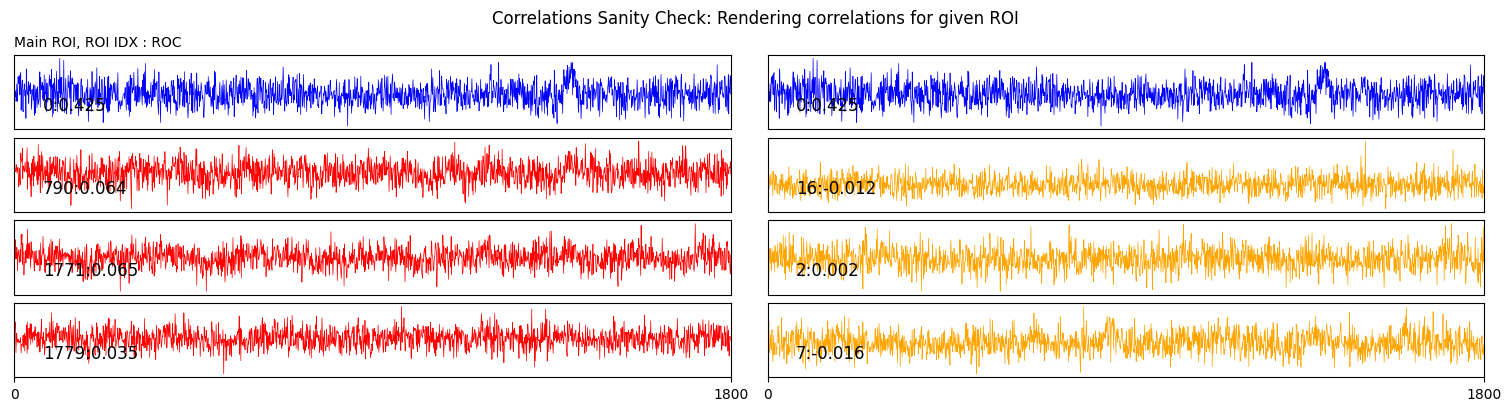

In [20]:
render_signal_correlations_for_roi(
    d0=d0,
    roi= 0,
    nn_arr=nn_three,
    rn_arr= rn_three,
    roi_roc = roi_roc,
    nn_corr = nn_three_corr[:3],
    rn_corr = rn_three_corr[:3],
)